# 光的折射与整数效应探究

光的折射中的斯涅尔定律：入射角与折射角的正弦比恒定不变，即 $\frac{\sin i}{\sin r} = \frac{n_{2}}{n_{1}}$， 其中n1,n2分别是两个介质的折射率。

将光的折射现象类比到股价中，有以下假设：
1. 当股价到达整数关口时，就可以认为是到达不同介质的临界点
2. 规定入射介质的折射率为1，出射介质折射率为n2
3. 通过入射线为过去10天close的线性回归的斜率，计算出入射角为i
4. 根据斯涅尔定律，折射角 $r = \sin^{-1}\left(\frac{1}{n_2}\sin i\right)$

此外，存在临界角 $i_{0} = \sin^{-1}\left(\frac{n_2}{n_1}\right)$，将出射光分为不同的情况：
1. n2>n1=1，则折射角r小于入射角i，价格穿过整数点且涨幅（斜率）变大
2. n2<1，则折射角r大于入射角i：<br>
   2.1. 若 $i < i_{0}$，折射，则价格会上涨，价格穿过整数点但涨幅变小<br>
   2.2. 若 $i = i_{0}$，折射角为90度（水平），价格在整数点周围徘徊<br>
   2.3. 若 $i > i_{0}$，全反射，价格会下跌，反射角约等于入射角
   
现在只需确定出射介质的折射率n2，也就是投资者对整数另一侧的预期态度:<br>
原论文介绍的公式为 $n_{2} = l * k* p$，其中：
$$l = \frac{NZC}{NZS} = \frac{\text{过去m天日收益为正的次数}}{\text{过去m天日收益为负的次数}}$$
$$k = \frac{VMT10}{VMTC} = \frac{\text{过去10天平均交易量}}{\text{过去m天日收益为正的交易日的平均交易量}}$$
$$p = \frac{PM10}{VI} = \frac{\text{过去10天平均交易价格}}{\text{整数值}}$$
这里折射率n2可以理解为市场的预期态度，n2越大代表对未来越乐观，越过整数点后更有可能上涨。

 在基本原理之上我又添加了一些优化条件。以上证指数为例，具体策略如下：
 1. 筛选出今天的close大于x、昨天的close小于x的日期点。其中x为任意100的倍数。即：<br>
 ```last_close < current_close and (current_close // 100 > last_close // 100)```<br>
  由于是日频数据，这是筛选穿越整数点的比较好的方法。**本策略暂时只考虑向上穿越的情况**，向下穿越的情况应当类似
 2. 回测2011年至今的数据，剔除2014-07-01到2015-07-01的数据。因为该时间段为大牛市，而本策略的预测结果为涨的居多，大牛市可能让策略的预测正确率过度的提高。
 3. 对于每个日期点，查看过去n天是否有穿越该整数的现象，若有则剔除。我们希望过去n天是单边的趋势，即都在整数的下方。若前几天已经到达过该整数，猜测将失去一定的整数效应
 3. 对于每个日期点，还需对股价进行标准化，因为不同尺度的股价会极大影响斜率，例如价格3000左右的上证指数和加固10以内的个股会产生极端的斜率。经过测试，将股价除以一个g.scale系数，调整在70左右比较合适。
 4. 线性回归计算斜率，若R方太差则剔除。注意这里的线性回归要求拟合直线经过最后一个数据点。此外，
 5. 计算出射折射率n2（窗口分别为n、m）
 6. 通过光折射模型预测出射斜率，返回预测结果

In [204]:
import numpy as np
import pandas as pd
import akshare as ak
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

class G:
    """
    全局对象 G，用来存储全局数据
    """
    pass

g = G()

# m，n为用于计算的时间窗口，可调整
g.m = 51
g.n = 10
g.integer_list = []

# 从akshare获取数据
def get_data():
    df = ak.stock_zh_index_daily(symbol="sh000001")
    df['date'] = pd.to_datetime(df['date'])  # 将 'date' 列转换为 datetime 对象
    # 筛选数据，并重置index
    filtered_df = df[df['date'].dt.year > 2010].reset_index(drop=True)
    # filtered_df = df[df['date'] > pd.Timestamp('2014-7-31')].reset_index(drop=True)
    g.data = df
    return filtered_df


# 寻找穿越整数的时间点
def time_list(df):
    close_series = df['close']
    shifted_close = close_series.shift(1)
    # 穿越整数的条件
    condition = (shifted_close < close_series) & ((close_series // 100) > (shifted_close // 100))
    indices = condition[condition].index.tolist()
    g.integer_list = indices

    # 获取穿越的的整数
    current_closest_hundred = close_series // 100 * 100
    # 检查前n天是否已经有穿过该整数的情况，若有则剔除(因为该策略最好需要的是单边的趋势)   
    # 另外删去2014-7-1至2015-7-1大牛市的数据
    filtered_list = []
    for index in g.integer_list:
        past_n_days = df.loc[max(0, index - g.n + 1): index - 1, 'close'] - current_closest_hundred.loc[index]
        date = df.loc[index, 'date']
        if (past_n_days < 0).all() and not (pd.Timestamp('2014-07-01') <= date <= pd.Timestamp('2015-07-01')):
            filtered_list.append(index)
    g.integer_list = filtered_list
    

    return

查看一下筛选出来的日期：

In [205]:
data = get_data()
integer_list = time_list(data)
print(len(g.integer_list))

95


In [214]:
# 计算入射角i
def angle_of_incidence(ten_days_close, i):
    '''
    对过去十天的close线性回归。要求是拟合线必须经过最后一个数据点。
    一个实现的方法就是将最后一个点设置为原点，然后要求拟合直线为y=kx不带截距的形式。
    param: 过去n天close的Series
    return: 入射角i，角度制
    '''
    # 在计算斜率的时候需要大致将股价调整到合适的尺度g.standard，暂定为60-70
    g.standard = 70
    # 这个scale是动态的，每个日期点的scale不同。
    g.scale = ten_days_close.mean() / g.standard
    ten_days_close = ten_days_close / g.scale
    
    X = np.arange(len(ten_days_close)).reshape(-1, 1)
    # 让所有的x值减去最后一个x值，所有的y值减去最后一个y值
    X_shifted = X - X[-1]
    y_shifted = ten_days_close - ten_days_close.iloc[-1]
    model = LinearRegression(fit_intercept=False).fit(X_shifted, y_shifted)   # 无截距
    slope = model.coef_[0]
    r_squared = model.score(X_shifted, y_shifted)
    if abs(r_squared) < 0.5 or slope < 0:
        g.integer_list.remove(i)
    elif g.k >= 1:
        g.slope.append(slope)        
    # 返回入射角i，角度制
    i_radians = np.arctan(slope)
    angle_i = 90 - np.degrees(i_radians)
    return angle_i

随便一组数据测试一下线性回归是否正确的经过了最后一个点：

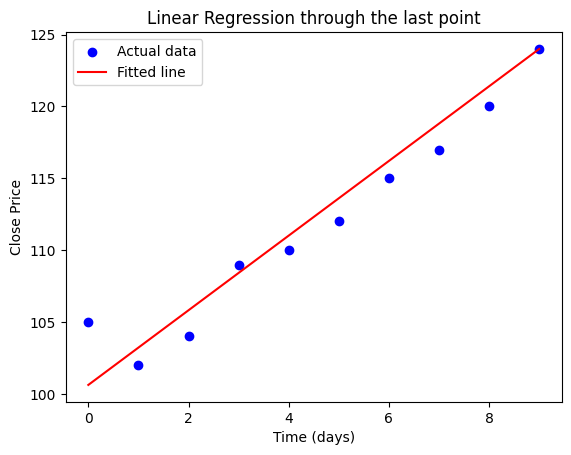

In [114]:
    ten_days_close = pd.Series([105, 102, 104, 109, 110, 112, 115, 117, 120, 124])
    X = np.arange(len(ten_days_close)).reshape(-1, 1)
    # 让所有的x值减去最后一个x值，所有的y值减去最后一个y值
    X_shifted = X - X[-1]
    y_shifted = ten_days_close - ten_days_close.iloc[-1]
    model = LinearRegression(fit_intercept=False).fit(X_shifted, y_shifted)   # 无截距
    slope = model.coef_[0]
    # 绘图
    y_fit = slope * (X - X[-1])
    plt.scatter(X, ten_days_close, color='blue', label='Actual data')
    plt.plot(X, y_fit + ten_days_close.iloc[-1], color='red', label='Fitted line')
    plt.title('Linear Regression through the last point')
    plt.xlabel('Time (days)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [215]:
#计算出射介质折射率n2
def refractive_n2(df):
    '''
    param: df
    return: n2的值
    '''
    df['daily_return'] = df['close'].diff()
    df = df[1:]
    # 计算过去 m 天内日收益为正、为负的日期数量
    positive_days = df['daily_return'].gt(0).sum()
    negative_days = df['daily_return'].lt(0).sum()
    l = positive_days / negative_days

    # 收益为正的日期对应的 'volume'的均值
    positive_return_volumes = df['volume'][df['daily_return'] > 0].mean()
    # 过去10天volume均值
    ten_days_volume = df[-10:]['volume'].mean()
    k = ten_days_volume / positive_return_volumes

    # 过去10天close均值
    ten_days_close = df[-10:]['close'].mean()
    # 整数值
    round_integer = df.iloc[-1]['close'] // 100 * 100
    p = ten_days_close / round_integer
    n2 = l * k * p
    return n2

In [233]:
# 预测趋势与真实数据比较结果，n0天
def compare_result(df, slope, i, n0 = 1):
    '''
    用于输出subplot以及预测方向是否正确    
    param: df, 预测的斜率
    return: None
    
    '''
    benchmark = df[i - g.n + 1: i + n0 + 1]['close'].reset_index(drop=True)
    start = df.iloc[i]['close']
    # predict前面有适当数量的 NaN 值
    padding = [np.nan] * (len(benchmark) - n0 - 1)
    # 别忘了把之前除掉的尺度乘回去
    predict = pd.Series(padding + [start + j * slope * g.scale for j in range(n0 + 1)])
    

    ax = plt.subplot(g.rows, g.cols, g.k)
    plt.plot(benchmark, label='Benchmark', marker='o')
    plt.plot(predict, label='Predict', linestyle='--', marker='x', color='red')
    plt.title('Benchmark vs Predict')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    
    # 预测的涨跌方向是否正确
    predict_dir = np.sign(predict.iloc[-1] - start)
    benchmark_dir = np.sign(benchmark.iloc[-1] - start)
    g.predict_direction.append(predict_dir)
    g.benchmark_direction.append(benchmark_dir)
    g.accuracy.append(predict_dir * benchmark_dir > 0)
    g.pre_list.append(slope * g.scale)
    g.real_list.append(benchmark.iloc[-1] - benchmark.iloc[-2])
    return
    
        

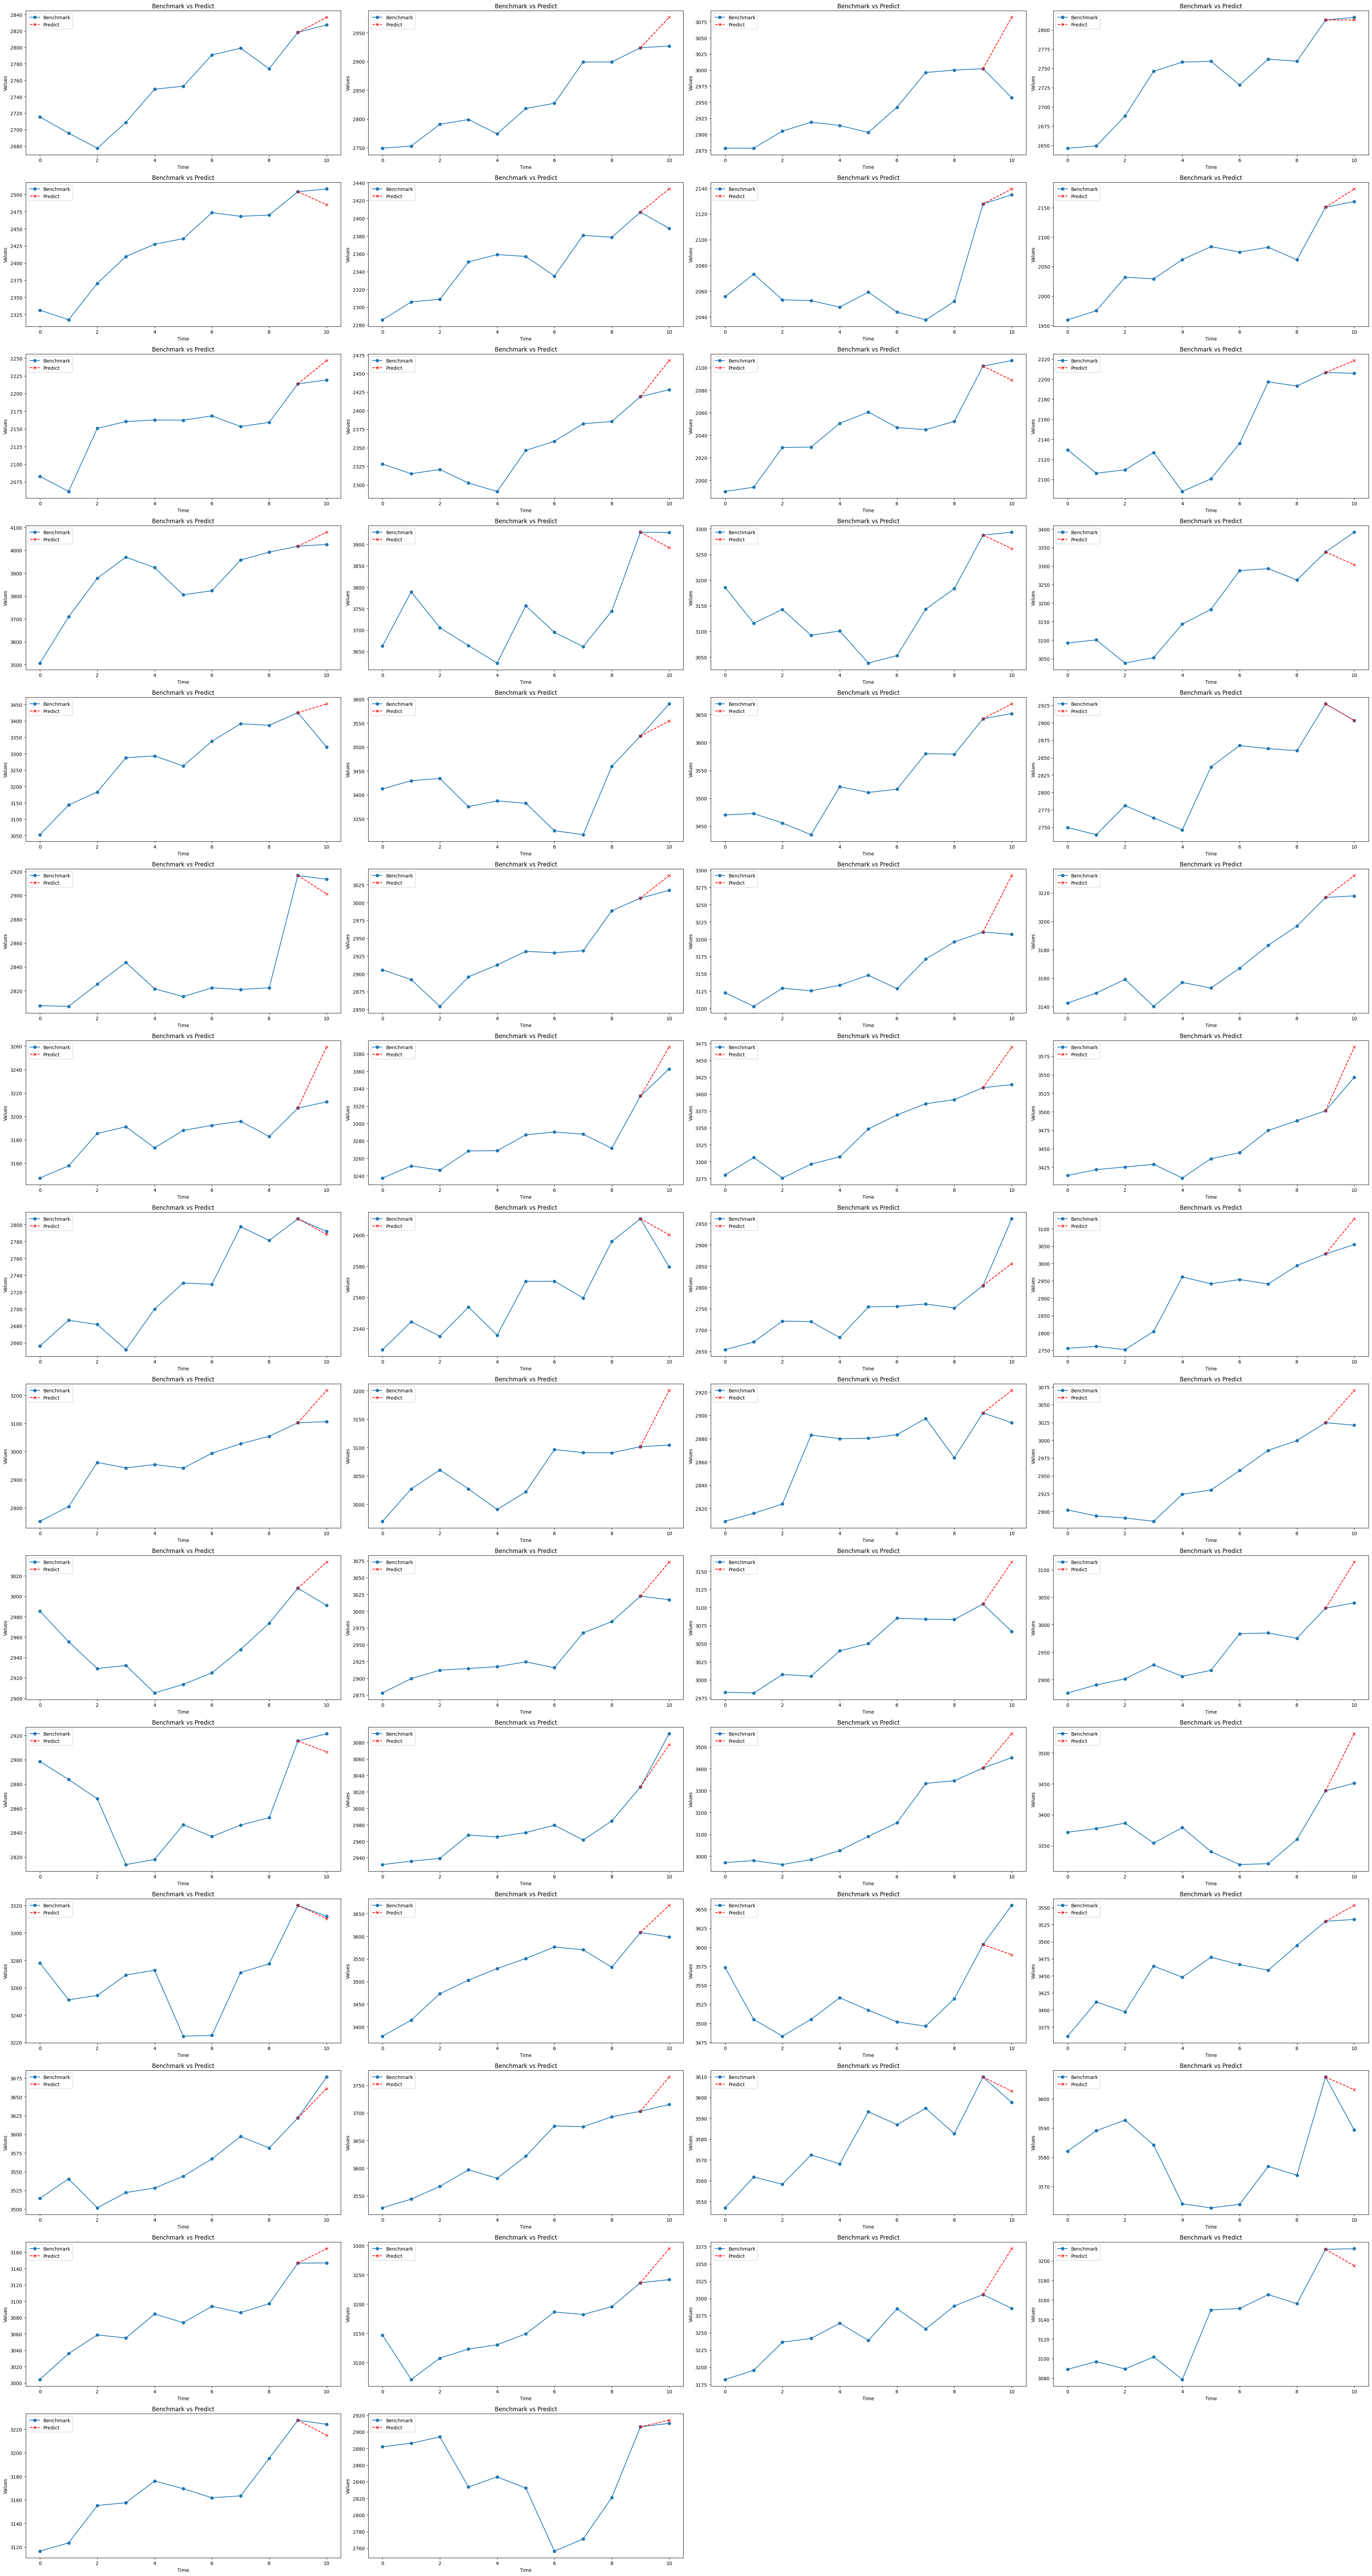

0.6551724137931034


,入射斜率,出射斜率,入射角i,出射角r,出射介质折射率n2,阈值i0,基准方向,预测方向,预测涨跌值,实际涨跌值
date,,,,,,,,,,
2011-02-10,0.385943,0.467741,68.896255,64.932598,1.029940,NaN,1.0,1.0,18.362857,9.165
2011-02-16,0.535874,1.314931,61.814281,37.252847,1.456092,NaN,1.0,1.0,53.035638,3.068
2011-03-09,0.360977,1.904389,70.151600,27.704087,2.023196,NaN,-1.0,1.0,79.817143,-45.011
2011-07-04,0.447149,0.000000,65.908224,90.000000,0.919378,66.835343,1.0,0.0,0.000000,3.537
2011-11-02,0.548645,-0.548645,61.248864,-61.248864,0.696434,44.141623,1.0,-1.0,-18.973326,3.982
2012-04-20,0.382313,0.777461,69.077481,52.136338,1.183148,NaN,-1.0,1.0,26.065976,-18.275
2012-09-07,0.386512,0.395807,68.867866,68.405971,1.003158,NaN,1.0,1.0,11.649383,7.131
2012-12-14,0.699950,1.057154,55.009905,43.408569,1.192165,NaN,1.0,1.0,30.976323,9.717
2012-12-25,0.449238,1.071928,65.808571,43.011759,1.337218,NaN,1.0,1.0,32.883980,5.521


In [237]:
# 主函数
def reflect_strategy(df):    

    # 用于画图的参数
    g.rows = len(g.integer_list) // 4 + 1
    g.cols = 4
    plt.figure(figsize=(10 * g.cols, 5 * g.rows))
    g.k = 0
    
    g.predict_direction = []
    g.benchmark_direction = []
    g.accuracy = []
    g.slope = []
    n2_list = []
    slope_after_list = []
    i_list = []
    i0_list = []
    r_list = []
    g.real_list = []
    g.pre_list = []
    
    # 先遍历一遍，剔除线性回归拟合效果差的日期点，确定最终日期点
    for i in g.integer_list:
        ten_days_close = df.loc[i - g.n + 1: i, 'close']
        angle_of_incidence(ten_days_close, i)
        
    # 再对最终确定使用的日期进行遍历    
    for i in g.integer_list:
        g.k += 1

        # 计算入射角i
        ten_days_close = df.loc[i - g.n + 1: i, 'close']
        angle_i = angle_of_incidence(ten_days_close, i)
        
        #计算出射介质折射率n2
        selected_date = df.loc[i, 'date']
        # 在 g.data 中寻找匹配的行（因为往前m日可能会早于data的范围，因此仍需要2011年之前的数据，存储在全局对象g中）
        matching_index = g.data[g.data['date'] == selected_date].index
        matching_i = matching_index[0]
        # 截取过去m+1天，多出来的第零天用于计算第一天的日收益
        start_index = max(matching_i - g.m, 0)
        end_index = matching_i + 1  # 包括匹配行
        # 使用 iloc 获取这个范围内的数据(用loc获取貌似会报错，因为“loc用于基于标签的索引，这里需要用 iloc来进行基于位置的索引”)
        m_days = g.data.iloc[start_index:end_index][['close', 'volume']]
        n2 = refractive_n2(m_days)

        if n2 >= 1:
            # 折射角小于入射角，价格上穿且涨幅增加
            angle_r = np.degrees(np.arcsin(np.sin(np.radians(angle_i))/n2))
            slope = np.tan(np.radians(90 - angle_r))
            i0 =  np.nan
        else:       
            # 计算临界值i0
            i0 =  np.degrees(np.arcsin(n2))
            if abs(angle_i -  i0) <= 1:
                # 全反射，在整数附近徘徊
                slope = 0
                angle_r = 90     # 折射角为90度，即水平
            elif angle_i < i0:
                # 折射角大于入射角，价格上穿且涨幅减小
                angle_r = np.degrees(np.arcsin(np.sin(np.radians(angle_i))/n2))
                slope = np.tan(np.radians(90 - angle_r))
            else:
                # 反射，价格反弹
                angle_r = - angle_i    #折射角（反射角）为负的入射角
                slope = - np.tan(np.radians(90 - angle_i))
        
        compare_result(df, slope, i)
        
        slope_after_list.append(slope)
        n2_list.append(n2)
        i_list.append(angle_i)
        i0_list.append(i0)
        r_list.append(angle_r)
    plt.tight_layout()
    plt.show()
    
    # return一些计算的指标
    output = pd.DataFrame(index=range(len(g.integer_list)), columns=['实际涨跌值'])
    output['入射斜率'] = g.slope
    output['出射斜率'] = slope_after_list
    output['入射角i'] = i_list 
    output['出射角r'] = r_list
    output['出射介质折射率n2'] = n2_list
    output['阈值i0'] = i0_list
    output['基准方向'] = g.benchmark_direction
    output['预测方向'] = g.predict_direction
    output['预测涨跌值'] = g.pre_list
    output['实际涨跌值'] = g.real_list
    output.index = df.loc[g.integer_list, 'date']
    
    columns = output.columns.tolist()[1:]
    columns.append(output.columns.tolist()[0])
    output = output[columns]
    
    g.output = output
    #输出预测方向的正确率
    print(g.accuracy.count(True) / len(g.accuracy))
    return output

reflect_strategy(data)

选取最近的几个时间点为例，蓝色为上证指数，红色为预测的下一日涨跌幅

In [238]:
g.output[-10:]

,入射斜率,出射斜率,入射角i,出射角r,出射介质折射率n2,阈值i0,基准方向,预测方向,预测涨跌值,实际涨跌值
date,,,,,,,,,,
2021-09-06,0.282974,0.775557,74.199869,52.204376,1.217686,NaN,1.0,1.0,39.352330,54.728
2021-09-10,0.374228,1.200683,69.482739,39.789545,1.463455,NaN,1.0,1.0,62.071595,12.262
2021-10-25,0.133101,-0.133101,82.418425,-82.418425,0.980013,78.525296,-1.0,-1.0,-6.802400,-12.225
2021-12-03,0.084978,-0.084978,85.142765,-85.142765,0.897610,63.845613,-1.0,-1.0,-4.345660,-18.126
2022-05-20,0.340766,0.403606,71.182630,68.020683,1.020740,NaN,1.0,1.0,17.721157,0.290
2022-06-06,0.380964,1.295602,69.144938,37.662473,1.529412,NaN,1.0,1.0,58.354030,5.392
2022-06-15,0.264998,1.436040,75.157878,34.851781,1.691532,NaN,-1.0,1.0,66.659346,-20.022
2022-12-05,0.375819,-0.375819,69.402834,-69.402834,0.754435,48.975986,1.0,-1.0,-16.799056,0.719
2023-01-16,0.279897,-0.279897,74.363214,-74.363214,0.786230,51.834618,-1.0,-1.0,-12.654018,-3.347


In [243]:
print(g.accuracy.count(True) / len(g.accuracy))    # 预测的方向的正确率

0.6551724137931034
25.0


42.64371931991409


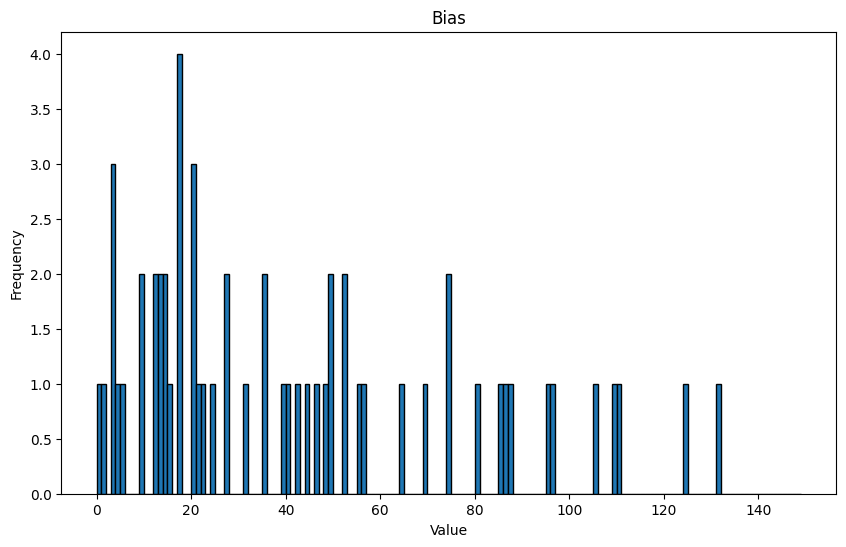

In [232]:
g.output['偏差'] = abs(g.output['实际涨跌值'] - g.output['预测涨跌值'])
print(g.output['偏差'].mean())
plt.figure(figsize=(10, 6))
plt.hist(g.output['偏差'], bins=range(0, 150), edgecolor='black')
plt.title('Bias')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

一些个人的想法与总结：
1. 由于整数效应应当是短期、迅速的，就仅用来预测后一天的涨跌幅。可以看到**预测效果一般**，涨跌方向的预测正确率为65.5%，很大一部分是由于那些时间本身就处于向上趋势，整数的效应并不明显。而斜率的预测几乎并没有效果。且预测方向的分类效果主要还是来源于折射率n2代表的市场态度预测，和光的折射模型关系不太大。
2. 这个策略可能本身就不适合日频。整数本质就像是一个阻力支撑位，预测的是这个阻力支撑位后面市场的短期走势。因此整数效应更应该适用于高频，也就是一出现整数则马上预测市场的反应，而不是像我这样选取日频的close价格分析。
3. 可以尝试改进优化的参数包括：计算斜率和折射率n2时用到的窗口n和m，股价需要放缩的尺度g.standard（我选取的是70）

潜在的改进方法：
1. 近10日的线性回归可以考虑改为带权重的，更侧重近几天的趋势
2. 感觉不如直接拿折射率n2来预测涨跌方向，预测斜率貌似没啥用...
3. 尝试不同的股票池，例如其他指数或者散户占比较高的个股等。我这个代码适用于1000以上的指数，如果回测个股的话则取整数的逻辑需要修改
